In [112]:
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
import scipy.optimize
from scipy.optimize import root
from scipy.optimize import fsolve

## SN Curve Prediction - Reverse Engineering

### Data Generation from an SN Curve

In [113]:
s_100 = 210.0
S_100 = s_100**2 # Stress Parameter

### Reverse Engineering the process to estimate S_uts (Ultimate Tensile Strength)

In [128]:
a_ar = np.array([0.40, 0.70, 0.40, 0.333])**2
b_ar = np.array([1.00, 1.00, 0.80, 0.666])**2

S_max = b_ar*S_100
S_min = a_ar*S_100

R = np.divide(S_min,S_max)

N  = [131300, 915400, 8664200, 173210400 ]

In [129]:
print(S_min)
print(S_max)

[ 7056.     21609.      7056.      4890.2049]
[44100.     44100.     28224.     19560.8196]


### Reverse Engineering the process to estimate m (slope of sn curve) and k in NS^m = k

#### Multi Variable linear regression

In [130]:
X_train = pd.DataFrame( {'x1':np.log(S_max),'x2':np.log( 0.5*(1-R)) } )
Y_train  = pd.DataFrame( np.log(N))

lm = linear_model.LinearRegression()
model_w = lm.fit(X_train,Y_train)

#print(X_train,Y_train)
#print(lm.coef_)
#print(lm.intercept_)

In [132]:
a1 = lm.coef_[0][0]*X_train['x1']
a2 = lm.coef_[0][1]*X_train['x2'] 
c  = lm.intercept_
a1+a2+c-Y_train[0]

0    0.011241
1    0.003303
2   -0.032248
3    0.017703
dtype: float64

In [133]:
#slope
m = -lm.coef_[0][0]
# gamma
g = lm.coef_[0][1]/lm.coef_[0][0]
# k
k = np.e**lm.intercept_[0]

In [134]:
print(m,g,k)

8.305760964697305 0.4666275775105438 1.73209494503752e+42


### Verification of results

In [135]:
a_ar_test = np.array([0.3333, 0.5833])**2
b_ar_test = np.array([0.8333, 0.8333])**2

N_test = np.array([2403300, 37737400])

In [168]:
a_ar_test = np.array([0.40, 0.70, 0.40, 0.333, 0.3333, 0.5833])**2
b_ar_test = np.array([1.00, 1.00, 0.80, 0.666, 0.8333, 0.8333])**2

N_test  = [131300, 915400, 8664200, 173210400, 2403300, 37737400]

S_min_test = a_ar_test*S_100
S_max_test = b_ar_test*S_100

R_test = np.divide(S_min_test, S_max_test)

S_e_test = S_max_test*(0.5*(1-R_test))**g


N_pred = k/S_e_test**m

print(N_pred,N_test)
error = np.round( 100*(N_pred/N_test -1),2)
print(error)

[1.32784259e+05 9.18428744e+05 8.38925797e+06 1.76304118e+08
 2.74610857e+06 1.89932639e+07] [131300, 915400, 8664200, 173210400, 2403300, 37737400]
[  1.13   0.33  -3.17   1.79  14.26 -49.67]


In [165]:
S_e_test

array([29419.56984987, 23308.4756216 , 17858.69851942, 12377.08262575,
       20428.84034023, 16185.39530623])

### Plots 

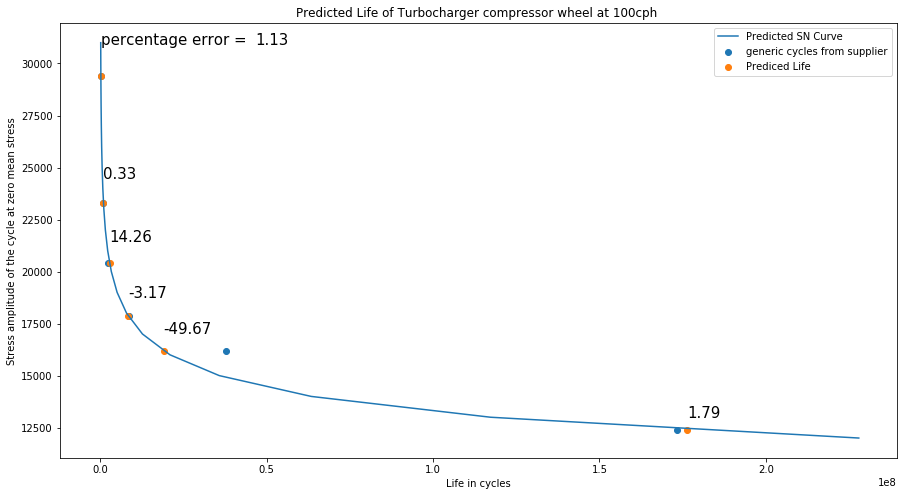

In [220]:
S_plot = range(12000,32000,1000)
N_plot = k/S_plot**m

fig= plt.figure(figsize=(15,8))
plt.plot(N_plot,S_plot,label= "Predicted SN Curve")
plt.scatter(N_test,S_e_test,label = "generic cycles from supplier")
plt.scatter(N_pred,S_e_test,label = "Prediced Life")
plt.xlabel('Life in cycles')
plt.ylabel('Stress amplitude of the cycle at zero mean stress')
plt.legend()

plt.text( N_pred[0],1.05*S_e_test[0],'percentage error = ',fontsize = 15)
plt.text( 350*N_pred[0],1.05*S_e_test[0],error[0],fontsize = 15)
plt.title('Predicted Life of Turbocharger compressor wheel at 100cph ')

for i in range(1,6):
    plt.text(N_pred[i],1.05*S_e_test[i],error[i],fontsize = 15)

plt.show()